### Dataset

In [11]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch import optim,nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from torchtoolbox.transform import Cutout

In [2]:
def default_loader(path):
    return Image.open(path).convert('RGB')

def change_2848_loader(path):
    img = Image.open(path).convert('RGB')
    
    if img.size[0] < 2800:
        return img
    else:
        img_pad = np.zeros((img.size[1] + 800, img.size[0], 3), dtype=np.uint8)
        img_pad[400:400+2848, 160:] = np.asanyarray(img)[:, :-160]
        img = Image.fromarray(img_pad)
        return img

class DatasetFromCSV(Dataset):
    def __init__(self, image_root, csv_path, transforms=None, loader=change_2848_loader):
        
        self.image_root = image_root
        
        self.data = pd.read_csv(csv_path)
        self.labels = np.asarray(self.data.iloc[:, 2:])
        
        # process image name
        imgs = []
        files_names = np.array(self.data.iloc[:, 0])
        for img in files_names:
            imgs.append(os.path.join(self.image_root, str(img)+'.png'))
        
        self.images = imgs
        self.transforms = transforms
        self.loader = loader
 
    def __getitem__(self, index):

        label = self.labels[index]
        img = self.images[index]
        img = self.loader(img)
        if self.transforms is not None:
            img = self.transforms(img)
        return img, label
    
    def __len__(self):
        return len(self.data.index)

class MyDataset(Dataset):
    def __init__(self, txt, transform=None, target_transform=None, loader=default_loader):
        fh = open(txt, 'r')
        imgs = []
        for line in fh:
            line = line.strip('\n')
            line = line.rstrip('\n')
            words = line.split()
            imgs.append((words[0],int(words[1])))
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = self.loader(fn)
        if self.transform is not None:
            img = self.transform(img)
        return img,label

    def __len__(self):
        return len(self.imgs)

### Transform

In [3]:
transform_color = [transforms.ColorJitter(brightness=0.5),
                       transforms.ColorJitter(contrast=0.5)
                      ]
transform_affine = [
#                     transforms.RandomAffine(0, shear=20),
                    transforms.RandomAffine(0, scale=(0.95, 1.05)),
                    transforms.RandomAffine(0, translate=(0.05, 0.05)),
                    transforms.RandomAffine(degrees=20)]

train_transform = transforms.Compose([
                transforms.Resize(size=(460), interpolation=Image.LANCZOS),
#                 transforms.CenterCrop(size=400),
                transforms.RandomApply(transform_affine, p=0.5),
                transforms.RandomHorizontalFlip(p=0.5), #随机水平翻转图片
                transforms.RandomApply(transform_color, p=0.5),
#                 Cutout(0.5, scale=(0.02, 0.2), ratio=(0.4, 2.5)),
                transforms.CenterCrop(size=480),
                transforms.ToTensor(), #将图片变成 Tensor，并且把数值normalize到[0,1]    
#                 transforms.Normalize([0.320, 0.197, 0.103], [0.317, 0.206, 0.128])
                        ])

### 得到均值与方差

In [7]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import os

train_transform = transforms.Compose([
    transforms.Resize((600, 600)), # 可以改成你图片近似大小或者模型要求大小
    transforms.ToTensor(),
])

# train_data= MyDataset("My_data/Training_Set/Training/", "My_data/Training_Set/RFMiD_Training_Labels.csv", train_transform)

# train_loader = torch.utils.data.DataLoader(train_data,batch_size=1000, shuffle=True)

batch_size = 500
root = "./My_data/"
train_dataset = MyDataset(txt=root + 'train.txt', transform=train_transform)
valid_dataset = MyDataset(txt=root + 'valid.txt', transform=train_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, num_workers=0)

train = iter(train_loader).next()[0]  # 500张图片的mean std
train_mean = np.mean(train.numpy(), axis=(0, 2, 3))
train_std = np.std(train.numpy(), axis=(0, 2, 3))

print(train_mean, train_std)

[0.49825245 0.52724576 0.38957652] [0.22746916 0.2125958  0.23409073]


### 图像分析

#### 训练集

In [17]:
train_txt = "My_data/train.txt"
data = open(train_txt, mode='r').readlines()[:36]

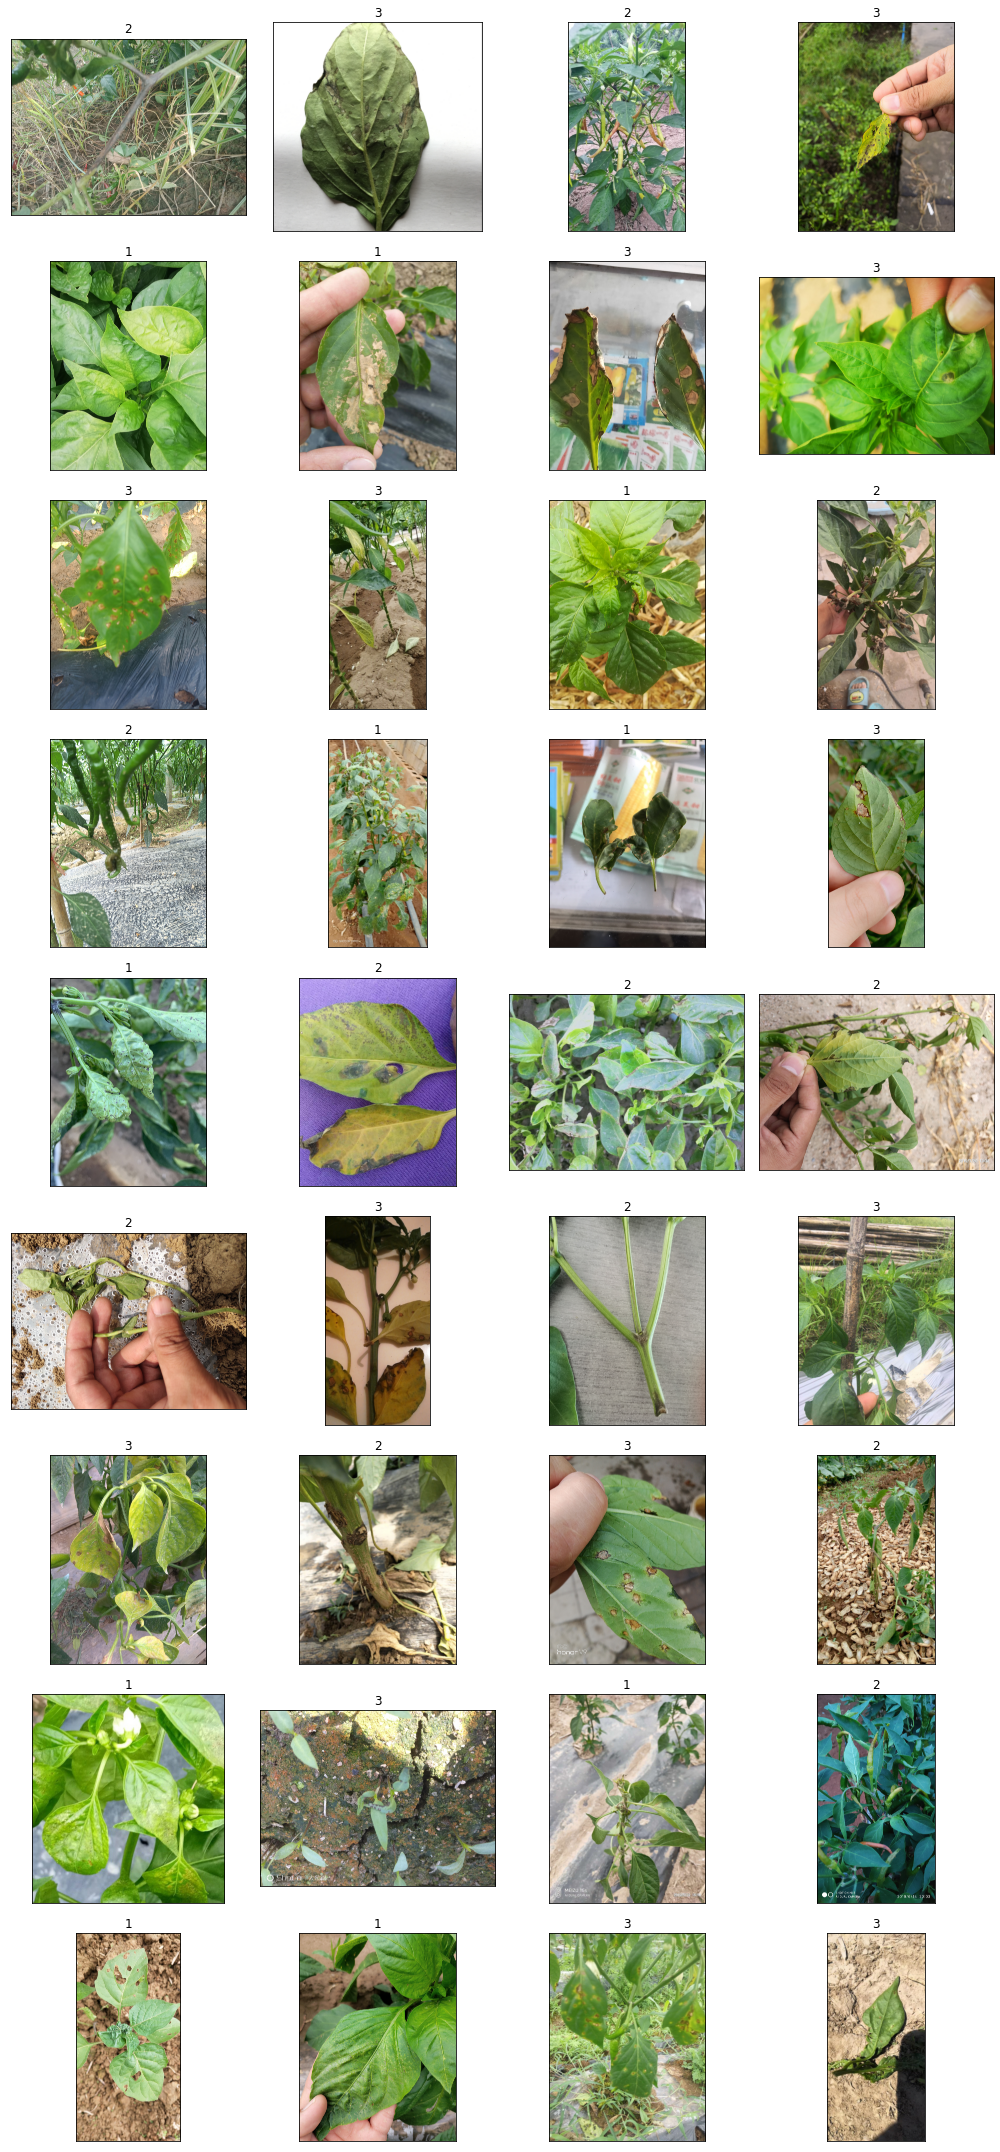

In [21]:
fig = plt.figure(figsize=(14, 30))
for i in range(len(data)):
    ax = fig.add_subplot(9, 4, i+1, xticks=[], yticks=[])
    file_name, label = data[i].rstrip("\n").split(" ")
    image = Image.open(file_name).convert("RGB")
    ax.imshow(image)
    ax.set_title(f"{int(label)+1}")
plt.tight_layout()
plt.show()

#### 测试集

In [23]:
test_path = "./My_data/Test_set/"
test_images = os.listdir(test_path)
len(test_images)

300

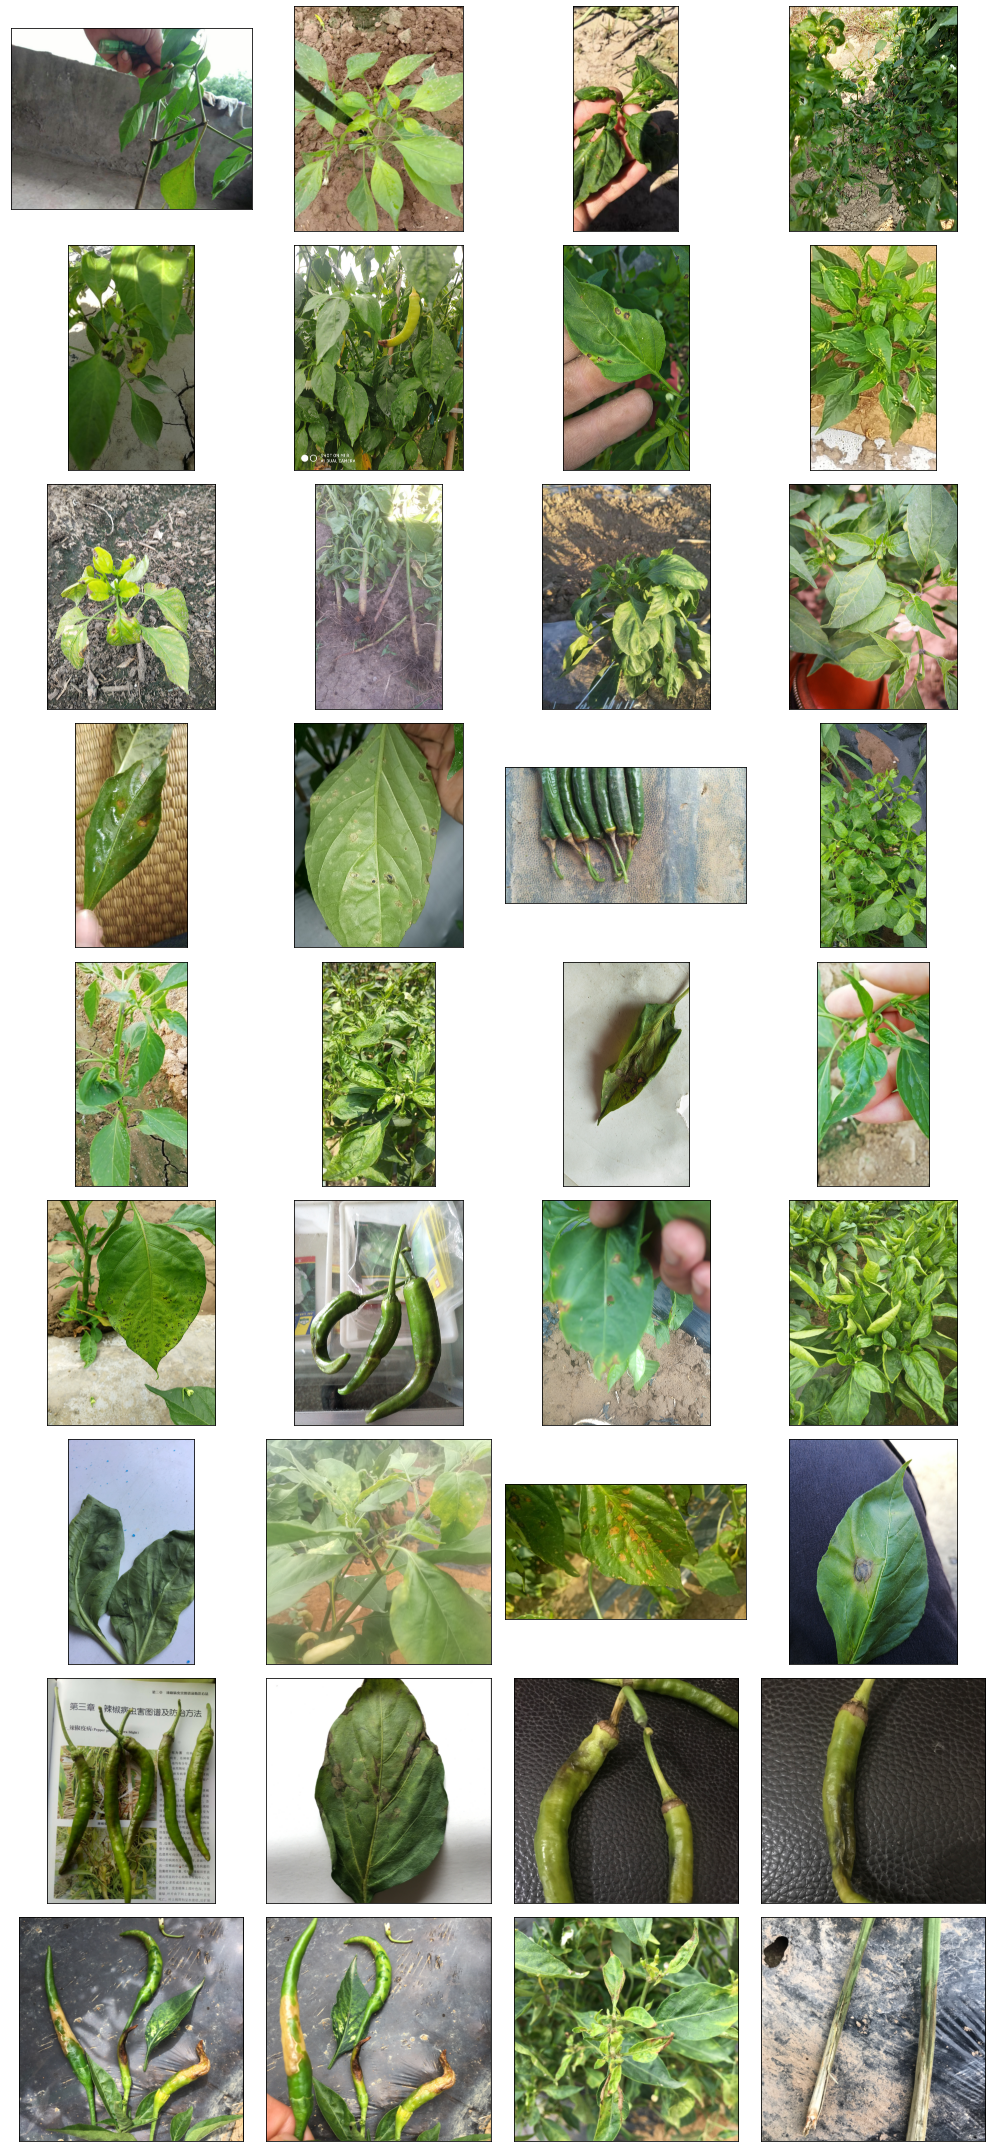

In [26]:
fig = plt.figure(figsize=(14, 30))
for i in range(len(test_images[:36])):
    ax = fig.add_subplot(9, 4, i+1, xticks=[], yticks=[])
    file_name = os.path.join(test_path, test_images[i])
    image = Image.open(file_name).convert("RGB")
    ax.imshow(image)
plt.tight_layout()
plt.show()